# apply instruments settings

In [1]:
import time
import sys
import os
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)

from hardware.pulser.pulser import PulseGenerator, OutputState, TriggerStart, TriggerRearm, HIGH, LOW, INF, REPEAT_INFINITELY
from hardware.laser.laser import LaserControl
from hardware.mw.mwsynthesizer import Synthesizer

from hardware import config_custom as hcf

import nidaqmx
from nidaqmx.constants import TerminalConfiguration, VoltageUnits, Edge, AcquisitionType, READ_ALL_AVAILABLE
# from nidaqmx.constants import LogicFamily 
# TWO_POINT_FIVE_V, THREE_POINT_THREE_V, FIVE_V
# from nidaqmx import stream_readers 
from nidaqmx.stream_readers import AnalogSingleChannelReader

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# connect to devices
uncal_choffset = {"laser":0, 
                "dclk":900, 
                "dtrig":900,
                "mwA":0, 
                "mwB":0,
                }
pg  = PulseGenerator(ip=hcf.PS_IP, chmap=hcf.PS_chmap, choffs=uncal_choffset) 
mwsyn = Synthesizer(hcf.VDISYN_SN, 
                    vidpid=hcf.VDISYN_VIDPID,
                    baudrate=hcf.VDISYN_BAUD, 
                    timeout=5, 
                    write_timeout=5)
# mwsyn.reboot()
laser = LaserControl(hcf.LASER_SN)
laser.open()

Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 192.168.1.26
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
VDI Sythesizer Serail Port Open


# Set parameters

In [3]:
# set current================================================
current_percent = 70.05
laser.laser_off()
laser.set_analog_control_mode("current")
laser.set_modulation_state("Pulsed")
laser.set_diode_current(current_percent, save_memory=False)

In [4]:
# set MW frequency =====================================================
f_NVguess = 398.5462701022625
# f_NVguess = 392.845
# f_NVguess = 398.555
freq = f_NVguess/24.0

errorbyte, freq_actual = mwsyn.cw_frequency(freq)
print(f"CW Freqeuncy Setting Sent:{freq} GHz")
print(f"Actual Output CW Freqeuncy :{freq_actual} GHz")

CW Freqeuncy Setting Sent:16.60609458759427 GHz
Actual Output CW Freqeuncy :16.60609458759427 GHz


In [5]:
# set MW power =====================================================
mwpower_vlevel = 5.0 # 5V equals to max power
task_uca = nidaqmx.Task("UCA") # user controlled attenuation
task_uca.ao_channels.add_ao_voltage_chan(hcf.NI_ch_UCA, min_val=0, max_val=10)
# task_uca.timing.cfg_samp_clk_timing(hcf.NI_sampling_max/100.0, sample_mode=AcquisitionType.CONTINUOUS)
task_uca.start()
task_uca.write([mwpower_vlevel], auto_start=False)
# task_uca.stop()
# task_uca.close()

1

In [6]:
# set MW phase =====================================================
mwphase_vlevel = 0.0 # voltage to phase shifter
task_mwbp = nidaqmx.Task("MW B Phase") # user controlled attenuation
task_mwbp.ao_channels.add_ao_voltage_chan(hcf.NI_ch_MWBP, min_val=0, max_val=10)
# task_uca.timing.cfg_samp_clk_timing(hcf.NI_sampling_max/100.0, sample_mode=AcquisitionType.CONTINUOUS)
task_mwbp.start()
task_mwbp.write([mwphase_vlevel], auto_start=False)
# task_uca.stop()
# task_uca.close()

1

In [7]:
def seqtime(seq_tb):
    return np.sum([pulse[-1] for pulse in seq_tb])

In [8]:
tb = hcf.NI_timebase
# init_laser = 8000.0

init_nslaser = 50
init_isc = 150
init_repeat = 40
init_wait = 1000.0

mw_dur_start = 10.0
mw_dur_end = 3500
mw_dur_step = 50
mw_dur = np.arange(mw_dur_start, mw_dur_end, mw_dur_step)[::-1] # reverse the mw 
mw_dur_num = len(mw_dur)
read_wait = 300.0
read_laser = 900.0

seq_exp = []

# construct the first seq for the first sweep parameter (which has the seq time)
# with MW
sub_init = [(["laser"], init_nslaser), ([], init_isc)]*init_repeat + [([], init_wait)]
# sub_init = [(["laser"], init_laser), ([], init_wait)]
sub_evo_MW = [(["mwB"], mw_dur[0])]
# sub_evo = [(["mwA"], mw_dur[0])]
# sub_evo = [([], mw_dur[0])]
sub_read = [([], read_wait), (["laser", "dclk"], read_laser)]
seq_exp += sub_init + sub_evo_MW + sub_read
seqlet_time_max = seqtime(seq_exp)
srate = 1/seqlet_time_max*1E9 # in Hz
# without MW
# sub_init = [(["laser"], init_laser), ([], init_wait)]
# sub_evo = [([], mw_dur[0]),([], mw_dur[0])]
sub_evo_noMW = [([], mw_dur[0])]
# sub_evo = [([], mw_dur[0])]
# sub_evo = [(["mwB"], mw_dur[0])]
seq_exp += sub_init + sub_evo_noMW + sub_read

# construct the remaining seq for sweep
for mwd in mw_dur[1:]:
    # with MW
    # sub_init = [(["laser"], init_laser), ([], init_wait)]
    sub_evo_MW = [(["mwB"], mwd)]
    # sub_evo_MW = [(["mwA"], mw_dur[0])]
    # sub_evo_MW = [([], mwd)]
    seqlet_MW = sub_init+sub_evo_MW+sub_read

    # padding for DAQ sampling
    seqlet_time = seqtime(seqlet_MW)
    padtime = seqlet_time_max - seqlet_time
    sub_pad = [([], padtime)]

    # without MW
    # sub_evo_noMW = [([], mwd), ([], mwd)]
    sub_evo_noMW = [([], mwd)]
    # sub_evo_noMW = [([], mwd)]
    # sub_evo_noMW = [(["mwB"], mwd)]
    seqlet_noMW = sub_init+sub_evo_noMW+sub_read

    # seq for one sweep
    seq_exp += sub_pad + seqlet_MW + sub_pad + seqlet_noMW 

# signal bias base for reference
trigwidth = tb*20
sub_dtrig = [(["dtrig"], trigwidth)]
sub_read = [([], read_wait), (["dclk"], read_laser)]
padtime = seqlet_time_max - seqtime(sub_dtrig) - seqtime(sub_read)
seqlet_bias = sub_dtrig + [([], padtime)] + sub_read 

total_time = pg.setSequence(
    seqlet_bias + seq_exp
) # WARNING only works well with small seq


In [9]:
pg.setTrigger(TriggerStart.SOFTWARE, rearm=TriggerRearm.AUTO)
REPEAT_INFINITELY = -1
pg.stream(n_runs=REPEAT_INFINITELY)
pg.plotSeq(plot_all=False)

In [10]:
# signal reading parameters
min_volt = -0.005 # [V]
max_volt = 0.010
samplerate_read = srate # 500kHz .max ext clock rate of NI6343, check it by yourself!
num_readmultiple = max(1, int(0.1/total_time*1E9))
num_readsample = mw_dur_num*2 + 1
buffer_size = num_readmultiple * num_readsample
timeout_read = max(2*buffer_size/samplerate_read, 10)
buffer_readpoint = np.zeros(buffer_size, dtype=np.float64, order='C')

readtask = nidaqmx.Task("readsignal")
# readtask.close()
readtask.ai_channels.add_ai_voltage_chan(
            hcf.NI_ch_APD,"",
            TerminalConfiguration.DIFF,
            min_volt,max_volt,
            VoltageUnits.VOLTS
        )
# readtask.timing.cfg_samp_clk_timing(samplerate_read, source="", active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=num_readsample)
readtask.timing.cfg_samp_clk_timing(
    samplerate_read, 
    source=hcf.NI_ch_Clock, 
    active_edge=Edge.RISING, 
    sample_mode=AcquisitionType.CONTINUOUS)
read_trig = readtask.triggers.start_trigger
read_trig.cfg_dig_edge_start_trig(hcf.NI_ch_Trig, Edge.RISING)

reader = AnalogSingleChannelReader(readtask.in_stream)
reader.read_all_avail_samp  = True

# Start measurement


In [11]:
laser.laser_on() # turn on laser

sig_mw_av = np.zeros(mw_dur_num, dtype=np.float64, order='C')
sig_no_av = np.zeros(mw_dur_num, dtype=np.float64, order='C')

read_duration = 4 # read data for ? seconds
num_repeat = 0
readtask.start() # ready to read data
pg.startNow()
start_time = time.time()
while time.time() - start_time < read_duration:
# for kkk in range(num_repeat):
    # readtask.start() # ready to read data
    num_read = reader.read_many_sample(
            buffer_readpoint,
            buffer_size,
            timeout_read
        )
    # readtask.wait_until_done(timeout=timeout_read) # block the code below, optional
    raw = np.reshape(buffer_readpoint, (num_readmultiple, num_readsample))
    bg_bias = np.copy(raw[:, 0])
    signal_mw = np.copy(raw[:, 1::2]).T - bg_bias 
    signal_nomw = np.copy(raw[:, 2::2]).T - bg_bias

    sig_mw_av += np.sum(signal_mw, axis=1)
    sig_no_av += np.sum(signal_nomw, axis=1)
    # readtask.stop()
    num_repeat += num_readmultiple


signal_av = sig_mw_av/num_repeat
background_av = sig_no_av/num_repeat
contrast = (sig_mw_av-sig_no_av)/sig_no_av
print(f"measurement repeat : {num_repeat} times")

measurement repeat : 2091 times


In [12]:
# turn off laser and set diode current to zero
laser.laser_off() 
laser.set_diode_current(0, save_memory=False)
laser.close()
# reset pulse generator
pg.forceFinal()
pg.constant(OutputState.ZERO())
pg.reset()
# pg.reboot()

# close all NI tasks
readtask.stop()
readtask.close()
task_uca.stop()
task_uca.close()
task_mwbp.stop()
task_mwbp.close()

# reboot(optional) and close the MW synthesizer 
# mwsyn.reboot()
mwsyn.close()

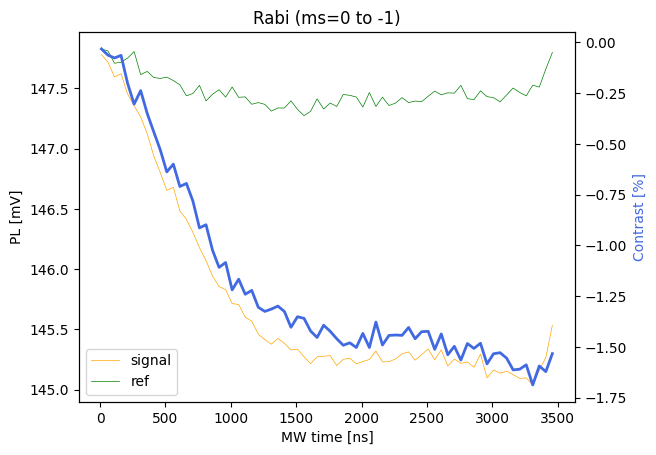

In [13]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
# ax1.plot(mw_dur, signal_av*1E3, linewidth=0.5, label="signal", color="orange")
# ax1.plot(mw_dur, background_av*1E3, linewidth=0.5, label="ref", color="green")
# ax2.plot(mw_dur, contrast*100.0, linewidth=2, label="contrast", color='royalblue')
idxstart = 0
idxend = len(mw_dur)
# idxend = 200
ax1.plot(mw_dur[idxstart:idxend], signal_av[idxstart:idxend]*1E3, linewidth=0.5, label="signal", color="orange")
ax1.plot(mw_dur[idxstart:idxend], background_av[idxstart:idxend]*1E3, linewidth=0.5, label="ref", color="green")
ax2.plot(mw_dur[idxstart:idxend], contrast[idxstart:idxend]*100.0, linewidth=2, label="contrast", color='royalblue')

ax1.set_xlabel("MW time [ns]")
ax1.set_ylabel("PL [mV]")
ax2.set_ylabel("Contrast [%]", color='royalblue')
ax1.legend(loc='best')
plt.title("Rabi (ms=0 to -1)")
plt.show()

In [14]:
# to save file
# Data to save
import pickle
data = {
    'mw_dur': mw_dur,
    'freq_actual': freq_actual,
    'signal_av': signal_av,
    'background_av': background_av, 
    'contrast': contrast, 
}

# File path
filename = "test_rabi_development_LP_21_90pol.pkl"
dir = "output\\20241118_rabidevelopment"
file_path = f'{dir}\\{filename}'

# Create the directory if it doesn't exist
os.makedirs(dir, exist_ok=True)

# Open the file in binary write mode and write data to it using pickle.dump()
with open(file_path, 'wb') as f:
    pickle.dump(data, f)

print(f'Data saved to {file_path}')

Data saved to output\20241118_rabidevelopment\test_rabi_development_LP_21_90pol.pkl


In [15]:
# File path
file_path = file_path
# file_path = "output\\20240508_coherence_measurement\\m1fid_400.0nspihalf_392.8397714495659.pkl"
# Open the file in binary read mode
with open(file_path, 'rb') as f:
    # Read data from the file using pickle.load()
    data = pickle.load(f)

# Access your data variables
mw_dur = data['mw_dur']
freq_actual = data['freq_actual']
signal_av = data['signal_av']
background_av = data['background_av']
contrast = data['contrast']

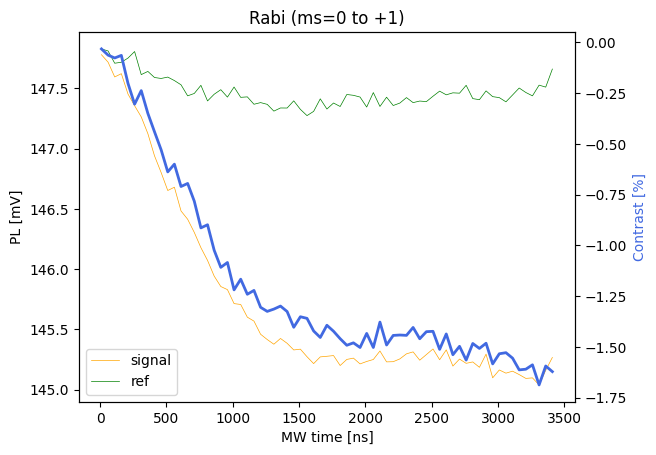

In [16]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
# ax1.plot(mw_dur, signal_av*1E3, linewidth=0.5, label="signal", color="orange")
# ax1.plot(mw_dur, background_av*1E3, linewidth=0.5, label="ref", color="green")
# ax2.plot(mw_dur, contrast*100.0, linewidth=2, label="contrast", color='royalblue')
idxstart = 1
idxend = len(mw_dur)
# idxend = 500
ax1.plot(mw_dur[idxstart:idxend], signal_av[idxstart:idxend]*1E3, linewidth=0.5, label="signal", color="orange")
ax1.plot(mw_dur[idxstart:idxend], background_av[idxstart:idxend]*1E3, linewidth=0.5, label="ref", color="green")
ax2.plot(mw_dur[idxstart:idxend], contrast[idxstart:idxend]*100.0, linewidth=2, label="contrast", color='royalblue')

ax1.set_xlabel("MW time [ns]")
ax1.set_ylabel("PL [mV]")
ax2.set_ylabel("Contrast [%]", color='royalblue')
ax1.legend(loc='best')
plt.title("Rabi (ms=0 to +1)")
plt.savefig(f'{dir}\\{filename}.png')
plt.show()


In [ ]:
import plotly.graph_objects as go

# Plot range
idxstart = 1
idxend = len(mw_dur)

# Create plotly figure with two y-axes
fig = go.Figure()

# Signal and Reference on the first y-axis
fig.add_trace(go.Scatter(x=mw_dur[idxstart:idxend], 
                         y=signal_av[idxstart:idxend] * 1E3, 
                         mode='lines', 
                         name='Signal [mV]', 
                         line=dict(color='orange', width=0.5)))

fig.add_trace(go.Scatter(x=mw_dur[idxstart:idxend], 
                         y=background_av[idxstart:idxend] * 1E3, 
                         mode='lines', 
                         name='Reference [mV]', 
                         line=dict(color='green', width=0.5)))

# Contrast on the second y-axis
fig.add_trace(go.Scatter(x=mw_dur[idxstart:idxend], 
                         y=contrast[idxstart:idxend] * 100.0, 
                         mode='lines', 
                         name='Contrast [%]', 
                         yaxis="y2",
                         line=dict(color='royalblue', width=2)))

# Update layout to add a second y-axis
fig.update_layout(
    title="Rabi (ms=0 to -1)",
    xaxis_title="MW time [ns]",
    yaxis_title="PL [mV]",
    yaxis2=dict(title="Contrast [%]", overlaying="y", side="right"),
    legend=dict(x=0.01, y=0.99)
)

# Show plot
fig.show()

ValueError: Invalid property specified for object of type plotly.graph_objs.layout.YAxis: 'voverlaying'

Did you mean "overlaying"?

    Valid properties:
        anchor
            If set to an opposite-letter axis id (e.g. `x2`, `y`),
            this axis is bound to the corresponding opposite-letter
            axis. If set to "free", this axis' position is
            determined by `position`.
        automargin
            Determines whether long tick labels automatically grow
            the figure margins.
        autorange
            Determines whether or not the range of this axis is
            computed in relation to the input data. See `rangemode`
            for more info. If `range` is provided, then `autorange`
            is set to False.
        autotypenumbers
            Using "strict" a numeric string in trace data is not
            converted to a number. Using *convert types* a numeric
            string in trace data may be treated as a number during
            automatic axis `type` detection. Defaults to
            layout.autotypenumbers.
        calendar
            Sets the calendar system to use for `range` and `tick0`
            if this is a date axis. This does not set the calendar
            for interpreting data on this axis, that's specified in
            the trace or via the global `layout.calendar`
        categoryarray
            Sets the order in which categories on this axis appear.
            Only has an effect if `categoryorder` is set to
            "array". Used with `categoryorder`.
        categoryarraysrc
            Sets the source reference on Chart Studio Cloud for
            `categoryarray`.
        categoryorder
            Specifies the ordering logic for the case of
            categorical variables. By default, plotly uses "trace",
            which specifies the order that is present in the data
            supplied. Set `categoryorder` to *category ascending*
            or *category descending* if order should be determined
            by the alphanumerical order of the category names. Set
            `categoryorder` to "array" to derive the ordering from
            the attribute `categoryarray`. If a category is not
            found in the `categoryarray` array, the sorting
            behavior for that attribute will be identical to the
            "trace" mode. The unspecified categories will follow
            the categories in `categoryarray`. Set `categoryorder`
            to *total ascending* or *total descending* if order
            should be determined by the numerical order of the
            values. Similarly, the order can be determined by the
            min, max, sum, mean or median of all the values.
        color
            Sets default for all colors associated with this axis
            all at once: line, font, tick, and grid colors. Grid
            color is lightened by blending this with the plot
            background Individual pieces can override this.
        constrain
            If this axis needs to be compressed (either due to its
            own `scaleanchor` and `scaleratio` or those of the
            other axis), determines how that happens: by increasing
            the "range", or by decreasing the "domain". Default is
            "domain" for axes containing image traces, "range"
            otherwise.
        constraintoward
            If this axis needs to be compressed (either due to its
            own `scaleanchor` and `scaleratio` or those of the
            other axis), determines which direction we push the
            originally specified plot area. Options are "left",
            "center" (default), and "right" for x axes, and "top",
            "middle" (default), and "bottom" for y axes.
        dividercolor
            Sets the color of the dividers Only has an effect on
            "multicategory" axes.
        dividerwidth
            Sets the width (in px) of the dividers Only has an
            effect on "multicategory" axes.
        domain
            Sets the domain of this axis (in plot fraction).
        dtick
            Sets the step in-between ticks on this axis. Use with
            `tick0`. Must be a positive number, or special strings
            available to "log" and "date" axes. If the axis `type`
            is "log", then ticks are set every 10^(n*dtick) where n
            is the tick number. For example, to set a tick mark at
            1, 10, 100, 1000, ... set dtick to 1. To set tick marks
            at 1, 100, 10000, ... set dtick to 2. To set tick marks
            at 1, 5, 25, 125, 625, 3125, ... set dtick to
            log_10(5), or 0.69897000433. "log" has several special
            values; "L<f>", where `f` is a positive number, gives
            ticks linearly spaced in value (but not position). For
            example `tick0` = 0.1, `dtick` = "L0.5" will put ticks
            at 0.1, 0.6, 1.1, 1.6 etc. To show powers of 10 plus
            small digits between, use "D1" (all digits) or "D2"
            (only 2 and 5). `tick0` is ignored for "D1" and "D2".
            If the axis `type` is "date", then you must convert the
            time to milliseconds. For example, to set the interval
            between ticks to one day, set `dtick` to 86400000.0.
            "date" also has special values "M<n>" gives ticks
            spaced by a number of months. `n` must be a positive
            integer. To set ticks on the 15th of every third month,
            set `tick0` to "2000-01-15" and `dtick` to "M3". To set
            ticks every 4 years, set `dtick` to "M48"
        exponentformat
            Determines a formatting rule for the tick exponents.
            For example, consider the number 1,000,000,000. If
            "none", it appears as 1,000,000,000. If "e", 1e+9. If
            "E", 1E+9. If "power", 1x10^9 (with 9 in a super
            script). If "SI", 1G. If "B", 1B.
        fixedrange
            Determines whether or not this axis is zoom-able. If
            true, then zoom is disabled.
        gridcolor
            Sets the color of the grid lines.
        griddash
            Sets the dash style of lines. Set to a dash type string
            ("solid", "dot", "dash", "longdash", "dashdot", or
            "longdashdot") or a dash length list in px (eg
            "5px,10px,2px,2px").
        gridwidth
            Sets the width (in px) of the grid lines.
        hoverformat
            Sets the hover text formatting rule using d3 formatting
            mini-languages which are very similar to those in
            Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display "09~15~23.46"
        layer
            Sets the layer on which this axis is displayed. If
            *above traces*, this axis is displayed above all the
            subplot's traces If *below traces*, this axis is
            displayed below all the subplot's traces, but above the
            grid lines. Useful when used together with scatter-like
            traces with `cliponaxis` set to False to show markers
            and/or text nodes above this axis.
        linecolor
            Sets the axis line color.
        linewidth
            Sets the width (in px) of the axis line.
        matches
            If set to another axis id (e.g. `x2`, `y`), the range
            of this axis will match the range of the corresponding
            axis in data-coordinates space. Moreover, matching axes
            share auto-range values, category lists and histogram
            auto-bins. Note that setting axes simultaneously in
            both a `scaleanchor` and a `matches` constraint is
            currently forbidden. Moreover, note that matching axes
            must have the same `type`.
        minexponent
            Hide SI prefix for 10^n if |n| is below this number.
            This only has an effect when `tickformat` is "SI" or
            "B".
        minor
            :class:`plotly.graph_objects.layout.yaxis.Minor`
            instance or dict with compatible properties
        mirror
            Determines if the axis lines or/and ticks are mirrored
            to the opposite side of the plotting area. If True, the
            axis lines are mirrored. If "ticks", the axis lines and
            ticks are mirrored. If False, mirroring is disable. If
            "all", axis lines are mirrored on all shared-axes
            subplots. If "allticks", axis lines and ticks are
            mirrored on all shared-axes subplots.
        nticks
            Specifies the maximum number of ticks for the
            particular axis. The actual number of ticks will be
            chosen automatically to be less than or equal to
            `nticks`. Has an effect only if `tickmode` is set to
            "auto".
        overlaying
            If set a same-letter axis id, this axis is overlaid on
            top of the corresponding same-letter axis, with traces
            and axes visible for both axes. If False, this axis
            does not overlay any same-letter axes. In this case,
            for axes with overlapping domains only the highest-
            numbered axis will be visible.
        position
            Sets the position of this axis in the plotting space
            (in normalized coordinates). Only has an effect if
            `anchor` is set to "free".
        range
            Sets the range of this axis. If the axis `type` is
            "log", then you must take the log of your desired range
            (e.g. to set the range from 1 to 100, set the range
            from 0 to 2). If the axis `type` is "date", it should
            be date strings, like date data, though Date objects
            and unix milliseconds will be accepted and converted to
            strings. If the axis `type` is "category", it should be
            numbers, using the scale where each category is
            assigned a serial number from zero in the order it
            appears.
        rangebreaks
            A tuple of
            :class:`plotly.graph_objects.layout.yaxis.Rangebreak`
            instances or dicts with compatible properties
        rangebreakdefaults
            When used in a template (as
            layout.template.layout.yaxis.rangebreakdefaults), sets
            the default property values to use for elements of
            layout.yaxis.rangebreaks
        rangemode
            If "normal", the range is computed in relation to the
            extrema of the input data. If *tozero*`, the range
            extends to 0, regardless of the input data If
            "nonnegative", the range is non-negative, regardless of
            the input data. Applies only to linear axes.
        scaleanchor
            If set to another axis id (e.g. `x2`, `y`), the range
            of this axis changes together with the range of the
            corresponding axis such that the scale of pixels per
            unit is in a constant ratio. Both axes are still
            zoomable, but when you zoom one, the other will zoom
            the same amount, keeping a fixed midpoint. `constrain`
            and `constraintoward` determine how we enforce the
            constraint. You can chain these, ie `yaxis:
            {scaleanchor: *x*}, xaxis2: {scaleanchor: *y*}` but you
            can only link axes of the same `type`. The linked axis
            can have the opposite letter (to constrain the aspect
            ratio) or the same letter (to match scales across
            subplots). Loops (`yaxis: {scaleanchor: *x*}, xaxis:
            {scaleanchor: *y*}` or longer) are redundant and the
            last constraint encountered will be ignored to avoid
            possible inconsistent constraints via `scaleratio`.
            Note that setting axes simultaneously in both a
            `scaleanchor` and a `matches` constraint is currently
            forbidden.
        scaleratio
            If this axis is linked to another by `scaleanchor`,
            this determines the pixel to unit scale ratio. For
            example, if this value is 10, then every unit on this
            axis spans 10 times the number of pixels as a unit on
            the linked axis. Use this for example to create an
            elevation profile where the vertical scale is
            exaggerated a fixed amount with respect to the
            horizontal.
        separatethousands
            If "true", even 4-digit integers are separated
        showdividers
            Determines whether or not a dividers are drawn between
            the category levels of this axis. Only has an effect on
            "multicategory" axes.
        showexponent
            If "all", all exponents are shown besides their
            significands. If "first", only the exponent of the
            first tick is shown. If "last", only the exponent of
            the last tick is shown. If "none", no exponents appear.
        showgrid
            Determines whether or not grid lines are drawn. If
            True, the grid lines are drawn at every tick mark.
        showline
            Determines whether or not a line bounding this axis is
            drawn.
        showspikes
            Determines whether or not spikes (aka droplines) are
            drawn for this axis. Note: This only takes affect when
            hovermode = closest
        showticklabels
            Determines whether or not the tick labels are drawn.
        showtickprefix
            If "all", all tick labels are displayed with a prefix.
            If "first", only the first tick is displayed with a
            prefix. If "last", only the last tick is displayed with
            a suffix. If "none", tick prefixes are hidden.
        showticksuffix
            Same as `showtickprefix` but for tick suffixes.
        side
            Determines whether a x (y) axis is positioned at the
            "bottom" ("left") or "top" ("right") of the plotting
            area.
        spikecolor
            Sets the spike color. If undefined, will use the series
            color
        spikedash
            Sets the dash style of lines. Set to a dash type string
            ("solid", "dot", "dash", "longdash", "dashdot", or
            "longdashdot") or a dash length list in px (eg
            "5px,10px,2px,2px").
        spikemode
            Determines the drawing mode for the spike line If
            "toaxis", the line is drawn from the data point to the
            axis the  series is plotted on. If "across", the line
            is drawn across the entire plot area, and supercedes
            "toaxis". If "marker", then a marker dot is drawn on
            the axis the series is plotted on
        spikesnap
            Determines whether spikelines are stuck to the cursor
            or to the closest datapoints.
        spikethickness
            Sets the width (in px) of the zero line.
        tick0
            Sets the placement of the first tick on this axis. Use
            with `dtick`. If the axis `type` is "log", then you
            must take the log of your starting tick (e.g. to set
            the starting tick to 100, set the `tick0` to 2) except
            when `dtick`=*L<f>* (see `dtick` for more info). If the
            axis `type` is "date", it should be a date string, like
            date data. If the axis `type` is "category", it should
            be a number, using the scale where each category is
            assigned a serial number from zero in the order it
            appears.
        tickangle
            Sets the angle of the tick labels with respect to the
            horizontal. For example, a `tickangle` of -90 draws the
            tick labels vertically.
        tickcolor
            Sets the tick color.
        tickfont
            Sets the tick font.
        tickformat
            Sets the tick label formatting rule using d3 formatting
            mini-languages which are very similar to those in
            Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display "09~15~23.46"
        tickformatstops
            A tuple of :class:`plotly.graph_objects.layout.yaxis.Ti
            ckformatstop` instances or dicts with compatible
            properties
        tickformatstopdefaults
            When used in a template (as
            layout.template.layout.yaxis.tickformatstopdefaults),
            sets the default property values to use for elements of
            layout.yaxis.tickformatstops
        ticklabelmode
            Determines where tick labels are drawn with respect to
            their corresponding ticks and grid lines. Only has an
            effect for axes of `type` "date" When set to "period",
            tick labels are drawn in the middle of the period
            between ticks.
        ticklabeloverflow
            Determines how we handle tick labels that would
            overflow either the graph div or the domain of the
            axis. The default value for inside tick labels is *hide
            past domain*. Otherwise on "category" and
            "multicategory" axes the default is "allow". In other
            cases the default is *hide past div*.
        ticklabelposition
            Determines where tick labels are drawn with respect to
            the axis Please note that top or bottom has no effect
            on x axes or when `ticklabelmode` is set to "period".
            Similarly left or right has no effect on y axes or when
            `ticklabelmode` is set to "period". Has no effect on
            "multicategory" axes or when `tickson` is set to
            "boundaries". When used on axes linked by `matches` or
            `scaleanchor`, no extra padding for inside labels would
            be added by autorange, so that the scales could match.
        ticklabelstep
            Sets the spacing between tick labels as compared to the
            spacing between ticks. A value of 1 (default) means
            each tick gets a label. A value of 2 means shows every
            2nd label. A larger value n means only every nth tick
            is labeled. `tick0` determines which labels are shown.
            Not implemented for axes with `type` "log" or
            "multicategory", or when `tickmode` is "array".
        ticklen
            Sets the tick length (in px).
        tickmode
            Sets the tick mode for this axis. If "auto", the number
            of ticks is set via `nticks`. If "linear", the
            placement of the ticks is determined by a starting
            position `tick0` and a tick step `dtick` ("linear" is
            the default value if `tick0` and `dtick` are provided).
            If "array", the placement of the ticks is set via
            `tickvals` and the tick text is `ticktext`. ("array" is
            the default value if `tickvals` is provided).
        tickprefix
            Sets a tick label prefix.
        ticks
            Determines whether ticks are drawn or not. If "", this
            axis' ticks are not drawn. If "outside" ("inside"),
            this axis' are drawn outside (inside) the axis lines.
        tickson
            Determines where ticks and grid lines are drawn with
            respect to their corresponding tick labels. Only has an
            effect for axes of `type` "category" or
            "multicategory". When set to "boundaries", ticks and
            grid lines are drawn half a category to the left/bottom
            of labels.
        ticksuffix
            Sets a tick label suffix.
        ticktext
            Sets the text displayed at the ticks position via
            `tickvals`. Only has an effect if `tickmode` is set to
            "array". Used with `tickvals`.
        ticktextsrc
            Sets the source reference on Chart Studio Cloud for
            `ticktext`.
        tickvals
            Sets the values at which ticks on this axis appear.
            Only has an effect if `tickmode` is set to "array".
            Used with `ticktext`.
        tickvalssrc
            Sets the source reference on Chart Studio Cloud for
            `tickvals`.
        tickwidth
            Sets the tick width (in px).
        title
            :class:`plotly.graph_objects.layout.yaxis.Title`
            instance or dict with compatible properties
        titlefont
            Deprecated: Please use layout.yaxis.title.font instead.
            Sets this axis' title font. Note that the title's font
            used to be customized by the now deprecated `titlefont`
            attribute.
        type
            Sets the axis type. By default, plotly attempts to
            determined the axis type by looking into the data of
            the traces that referenced the axis in question.
        uirevision
            Controls persistence of user-driven changes in axis
            `range`, `autorange`, and `title` if in `editable:
            true` configuration. Defaults to `layout.uirevision`.
        visible
            A single toggle to hide the axis while preserving
            interaction like dragging. Default is true when a
            cheater plot is present on the axis, otherwise false
        zeroline
            Determines whether or not a line is drawn at along the
            0 value of this axis. If True, the zero line is drawn
            on top of the grid lines.
        zerolinecolor
            Sets the line color of the zero line.
        zerolinewidth
            Sets the width (in px) of the zero line.
        
Did you mean "overlaying"?

Bad property path:
voverlaying
^^^^^^^^^^^